### API for coordinates

In [45]:
import requests
import numpy as np
import pandas as pd
import json
import geopandas as gpd

In [46]:
address = "Dreveneind 1, 2910 Essen" 

In [47]:
def get_coordinates(address: str):
    req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()
    info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality']}
    
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
                          params={"postcode": info['postcode'], 
                                  "straatnaam": info['street'],
                                  "huisnummer": info['house_number']}).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    info['polygon'] = [build['geometriePolygoon']['polygon']]
    return info['polygon'][0]['coordinates'][0] 

In [48]:
adresss_coordination = get_coordinates(address)
adresss_coordination

[[159362.70088172704, 239936.7117844522],
 [159351.41384171695, 239941.70557645336],
 [159347.94644971192, 239934.70359244943],
 [159342.96244971454, 239937.03754445165],
 [159338.10510570556, 239926.8673684448],
 [159341.3973937109, 239925.33898444474],
 [159341.5757617131, 239925.69533644244],
 [159342.15035370737, 239925.4817044437],
 [159343.78683371097, 239924.87306444347],
 [159345.2128817141, 239928.08138444647],
 [159343.59444971383, 239928.81956044585],
 [159343.1514417082, 239929.02167244628],
 [159344.22536171228, 239931.28880844638],
 [159344.5845297128, 239931.10794444755],
 [159346.35835371166, 239930.21488844603],
 [159346.8604977131, 239931.15453644842],
 [159347.06555371732, 239931.53828044608],
 [159358.13678572327, 239926.30180044472],
 [159362.70088172704, 239936.7117844522]]

In [49]:
from shapely.geometry import Polygon

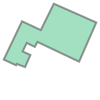

In [50]:
polygon_shapely = Polygon(adresss_coordination)
polygon_shapely

In [51]:
x_adresss_coordination = [x[0] for x in adresss_coordination]
y_adresss_coordination = [x[1] for x in adresss_coordination]

x_left = min(x_adresss_coordination)
x_right = max(x_adresss_coordination)
y_bottom = min(y_adresss_coordination)
y_top = max(y_adresss_coordination)

(x_left, x_right, y_bottom, y_top)

(159338.10510570556,
 159362.70088172704,
 239924.87306444347,
 239941.70557645336)

In [52]:
import shapefile

In [53]:
write = shapefile.Writer("shapefiles/test/polygon")
write.field("name", "C")

write.poly([adresss_coordination])
write.record("polygon_1")

write.close()

In [54]:
pwd

'/home/becode/3D-House/3D-House-Project'

<AxesSubplot:>

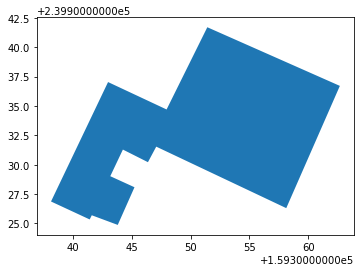

In [55]:
# Read test file

path = "/home/becode/3D-House/3D-House-Project/shapefiles/test/polygon.shp"
test = gpd.read_file(path)
test.plot()